The object detection model to detect one of the following PPE classes: 

**['Helmet', 'Mask', 'NO-Helmet', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']** 


We will import the following libraries for visualizations and model building.
- `os` and `glob` for accessing file directories
- `tqdm` for  estimates how long the process would take to complete 
- `numpy` for array operations
- `pandas` for dataframes
- `PIL` and `cv2` for Image oparations and visualization
- `matplotlib` for plotting results and class distributions

In [ ]:
%matplotlib inline
import os, glob
import tqdm
import numpy as np
import pandas as pd
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import warnings
import matplotlib.pyplot as plt
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Flatten,Dense,Conv2D,MaxPool2D,Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
warnings.filterwarnings('ignore')

Reading Data 

In [ ]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)
# Data path
data_path = '/content/drive/MyDrive/Internship/archive/css-data/'
# Train, Valid and Test path  
train_path = os.path.join(data_path, 'train')
valid_path = os.path.join(data_path, 'valid')
test_path = os.path.join(data_path, 'test')
# For saving results
output_path = '/Desktop/gow/'
# We can access both images and labels
folders = ['images', 'labels']

Mounted at /content/drive


Creating classes for object detection.

In [ ]:
# Initialize dictionaries of training and classes
train_dict = dict(train=0, valid=1, test=2)
path_dict = [train_path, valid_path, test_path]
class_names = ['Helmet', 'Mask', 'NO-Helmet', 'NO-Mask', 'NO-Safety Vest', 'Person', 'Safety Cone', 'Safety Vest', 'machinery', 'vehicle']
class_dict = dict(zip(range(len(class_names)), class_names))#By assigning numeric ID to each class, we can will be able link results back to class names
print(class_dict)

{0: 'Helmet', 1: 'Mask', 2: 'NO-Helmet', 3: 'NO-Mask', 4: 'NO-Safety Vest', 5: 'Person', 6: 'Safety Cone', 7: 'Safety Vest', 8: 'machinery', 9: 'vehicle'}


In [ ]:
## Get filenames and labels information
# Sorting the filenames will make the labels and images in same order 
train_filenames = sorted(os.listdir(os.path.join(train_path, folders[0])))#return a list containing the names of the files in the directory.
valid_filenames = sorted(os.listdir(os.path.join(valid_path, folders[0])))
test_filenames = sorted(os.listdir(os.path.join(test_path, folders[0])))
train_labels = sorted(os.listdir(os.path.join(train_path, folders[1])))
valid_labels = sorted(os.listdir(os.path.join(valid_path, folders[1])))
test_labels = sorted(os.listdir(os.path.join(test_path, folders[1])))

In [ ]:
# Return lengths of all filenames
print("Total Train Files: {}\nTotal Valid Files: {}\nTotal Test Files:{}".format(len(train_filenames), len(valid_filenames), len(test_filenames)))

Total Train Files: 2605
Total Valid Files: 114
Total Test Files:82


In [ ]:
# Check whether filenames and labels are of same length
len(train_filenames)==len(train_labels), len(valid_filenames)==len(valid_labels), len(test_filenames)==len(test_labels)

(True, True, True)


The order of filenames and labels of each image has the same label annotation name as that of the image. This will ensure that we are not using annotations and label information for a different image.

In [ ]:
df = pd.DataFrame()
df['filenames'] = train_filenames + valid_filenames + test_filenames
df['labelnames'] = train_labels + valid_labels + test_labels
df['train_id'] = [0]*len(train_filenames) + [1]*len(valid_filenames) + [2]*len(test_filenames)

In [ ]:
df.head()

filenames  \
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...   
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...   
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...   
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...   
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...   

                                          labelnames  train_id  
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...         0  
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...         0  
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...         0  
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...         0  
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...         0

In [ ]:
df.tail()

filenames  \
2796  youtube-596_jpg.rf.11a8a4ac01d8aadb80eeb0406df...   
2797  youtube-631_jpg.rf.7c6ecf859c1b0a659f8ea057ad2...   
2798  youtube-671_jpg.rf.7b08643d6754cabe6caf2b49a96...   
2799  youtube-738_jpg.rf.6f300b76e12b325f7c373c95ef3...   
2800  youtube-840_jpg.rf.974a83a7c5aee7c16e83435b043...   

                                             labelnames  train_id  
2796  youtube-596_jpg.rf.11a8a4ac01d8aadb80eeb0406df...         2  
2797  youtube-631_jpg.rf.7c6ecf859c1b0a659f8ea057ad2...         2  
2798  youtube-671_jpg.rf.7b08643d6754cabe6caf2b49a96...         2  
2799  youtube-738_jpg.rf.6f300b76e12b325f7c373c95ef3...         2  
2800  youtube-840_jpg.rf.974a83a7c5aee7c16e83435b043...         2

###  Check Duplicate Entries

In [ ]:
# No duplicate entries found
df.filenames.duplicated().value_counts()

False    2801
Name: filenames, dtype: int64

In [ ]:
# Count of train valid and test sets
df.train_id.value_counts()

0    2605
1     114
2      82
Name: train_id, dtype: int64

<AxesSubplot:title={'center':'Train-Val-Test Split'}>

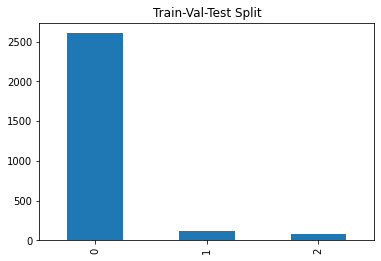

In [ ]:
df.train_id.value_counts().plot(kind = 'bar', title = 'Train-Val-Test Split')

In [ ]:
# Split list
train_keys = list(train_dict.keys())

In [ ]:
print(train_keys)

['train', 'valid', 'test']


In [ ]:
# Complete path for annotation_files
# the process of labeling or classifying an image using text, annotation tools, or both, 
#to show the data features you want your model to recognize on its own.
annotation_files = (data_path + '/' + df.train_id.map(lambda x: train_keys[x]) + '/' + folders[1]
                    + '/' + df.labelnames).tolist()
t_id = df.train_id.tolist()
counts = []
invalid_idx = []
is_annotated = []
for idx, annotation_file in tqdm.tqdm(enumerate(annotation_files)):
    annotation = np.loadtxt(annotation_file)
    if len(annotation)==0:
        invalid_idx.append(idx)
        is_annotated.append(-1)
        counts.append([])
        continue
    if len(annotation.shape)==1:
        annotation = annotation.reshape(1, -1)
    counts.append(annotation[:,0].astype(int))
    is_annotated.append(1)
df['is_annotated'] = is_annotated

2801it [02:15, 20.74it/s]


In [ ]:
df.head()

filenames  \
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...   
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...   
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...   
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...   
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...   

                                          labelnames  train_id  is_annotated  
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...         0             1  
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...         0             1  
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...         0             1  
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...         0             1  
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...         0             1

In [ ]:
count_list = [np.unique(item, return_counts = True) for item in counts]
count_keys = [item[0] for item in count_list]
count_values = [item[1] for item in count_list]
count_dict = []
for ck,cv in zip(count_keys, count_values):
    count_dict.append(dict([(key,value) for key, value in zip(ck,cv)]))
df['count_dict'] = count_dict

In [ ]:
df.head()

filenames  \
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...   
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...   
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...   
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...   
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...   

                                          labelnames  train_id  is_annotated  \
0  -1670-_png_jpg.rf.0463edb430019e01ec79eed27a63...         0             1   
1  -1670-_png_jpg.rf.3cb172ea2c4165c19ae2dd498b38...         0             1   
2  -1670-_png_jpg.rf.7da967f9aeaa62defc36543b9e60...         0             1   
3  -1670-_png_jpg.rf.b42b26d784545ce1a033679674a4...         0             1   
4  -1670-_png_jpg.rf.dd5cb0a4d6da02d34f1dc003fb4e...         0             1   

                                   count_dict  
0              {0: 2, 1: 2, 2: 2, 3: 2, 5: 4}  
1              {0: 2, 3: 2, 4: 4, 5: 9, 7: 2}  
2              {0: 1, 2: 1, 4: 2, 5: 2, 8: 2}  
3              {0: 3, 3: 3, 4: 3, 5: 7, 8: 6}  
4  {0: 2, 2: 1, 3: 3, 4: 2, 5: 6, 7: 1, 8: 5}

In [ ]:
from collections import Counter
train_count = df[df.train_id==0].count_dict.apply(lambda x: Counter(x)).sum()
valid_count = df[df.train_id==1].count_dict.apply(lambda x: Counter(x)).sum()
test_count = df[df.train_id==2].count_dict.apply(lambda x: Counter(x)).sum()

In [ ]:
train_count = {key:value/sum(train_count.values()) for key, value in train_count.items()}
valid_count = {key:value/sum(valid_count.values()) for key, value in valid_count.items()}
test_count = {key:value/sum(test_count.values()) for key, value in test_count.items()}

In [ ]:
print("Train Class Distribution Dict: {}\n\nValid Class Distribution Dict: {}\n\nTest Class Distribution Dict: {}"
     .format(train_count, valid_count, test_count))

Train Class Distribution Dict: {0: 0.08524190269684238, 1: 0.04474861092288928, 2: 0.06279983737633826, 3: 0.08394091340290012, 5: 0.2583547906220355, 4: 0.10738582463748475, 7: 0.0822062610109771, 8: 0.14221439219406423, 6: 0.09123187423770159, 9: 0.04187559289876677}

Valid Class Distribution Dict: {0: 0.1133428981348637, 3: 0.10616929698708752, 4: 0.15208034433285508, 5: 0.2381635581061693, 7: 0.058823529411764705, 2: 0.09899569583931134, 1: 0.03012912482065997, 6: 0.06312769010043041, 8: 0.07890961262553801, 9: 0.06025824964131994}

Test Class Distribution Dict: {0: 0.14473684210526316, 3: 0.10394736842105264, 4: 0.11842105263157894, 5: 0.22894736842105262, 6: 0.12105263157894737, 9: 0.05394736842105263, 2: 0.05394736842105263, 7: 0.08026315789473684, 8: 0.05789473684210526, 1: 0.03684210526315789}


In [ ]:
df_count = pd.DataFrame()
df_count = pd.DataFrame({'train':train_count, 'valid': valid_count, 'test': test_count}).sort_index()
df_count.head()

train     valid      test
0  0.085242  0.113343  0.144737
1  0.044749  0.030129  0.036842
2  0.062800  0.098996  0.053947
3  0.083941  0.106169  0.103947
4  0.107386  0.152080  0.118421

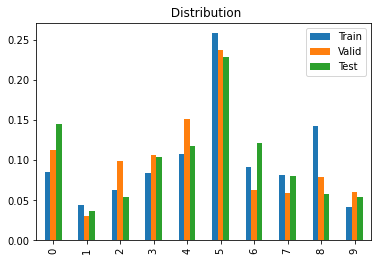

In [ ]:
df_count.plot(y = ['train', 'valid', 'test'], kind = 'bar', title = ' Distribution')
plt.legend(['Train', 'Valid', 'Test'])

# Visualize Samples
Let us visualize some samples from the dataset and their annotations. Since we have all the annotations in YoloV8 format we will start with converting these annotation files to bounding box coordinates.

YoloV8 format for annotation has 5 entries in each line of the txt file. 
- Class Label (c)
- Bounding Box's center (X coordinate)
- Bounding Box's center (Y coordinate)
- Width of Bounding Box (w)
- Height of Bounding Box (h)

The bounding box can be calculated from the last 4 entries in the annotation file.
  Converts Yolo annotations to bounding box coordinates
  Input:
  annotation: str, annotation file in .txt format
  img_height: int, image height
  img_width: int, image width
  Output:
  class: list, List of labels in the image
  bbox_list: list, List of bounding boxes in an image
  The process of labeling or classifying an image using text, annotation tools, or both, to show the data features you want your model to recognize on its own

In [ ]:
def yolo_annotation_to_bbox(annotation, img_height, img_width):
 
    sh = annotation.shape
    if len(sh)==0:
        print("No bounding box found")
    if len(sh)==1:
        annotation = annotation.reshape(1, -1)
    num_bbox = len(annotation)
    bbox_list = []
    for idx in range(num_bbox):
        c_x, c_y, w, h = annotation[idx][1:]
        x1 = ((c_x - w/2)*img_width).astype(int)
        x2 = ((c_x + w/2)*img_width).astype(int)
        y1 = ((c_y - h/2)*img_height).astype(int)
        y2 = ((c_y + h/2)*img_height).astype(int)
        bbox_list.append([x1, y1, x2, y2])
    return bbox_list

In [ ]:
### invalid_files = (data_path + '/' + df.train_id[invalid_idx].apply(lambda x: train_keys[x]) + '/' + folders[0] + '/' + df.filenames[invalid_idx])
invalid_files = df.filenames[invalid_idx]
def visualize_samples(mode = 'train', n_samples = 12):
    """
    Plots 'n_samples' plots from train/valid/test split
    Input:
    mode: 'str' can take values from 'train'/'valid','test'
    n_samples: 'int'
    """
    # We will visualize only those files which have annotations 
    indices = df[(~df.filenames.isin(invalid_files))&(df.train_id==1)].sample(n_samples).index
    filenames = (data_path + '/' + df.train_id[indices].apply(lambda x: train_keys[x]) + '/' + folders[0] + '/' + df.filenames[indices]).tolist()
    annotations = (data_path + '/' + df.train_id[indices].apply(lambda x: train_keys[x]) + '/' + folders[1] + '/' + df.labelnames[indices]).tolist()
    plt.figure(figsize = (21, 11))
    plt.title('{} Set Samples'.format(mode.upper()))
    for idx in range(len(filenames)):
        image = np.array(Image.open(filenames[idx]))
        height, width, _ = image.shape 
        annotation = np.loadtxt(annotations[idx])
        bbox_list = yolo_annotation_to_bbox(annotation, height, width)
        if len(annotation.shape)==1:
            annotation = annotation.reshape(1, -1)
        labels = [class_dict[item] for item in annotation[:,0].astype(int)]
        plt.subplot(3, 4, idx + 1)
        for label, bbox in zip(labels, bbox_list):
            x1, y1, x2, y2 = bbox
            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(image, label, (x1, y1-5), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (255, 0, 0), 2)
        plt.imshow(image)
    plt.tight_layout()
    plt.show()

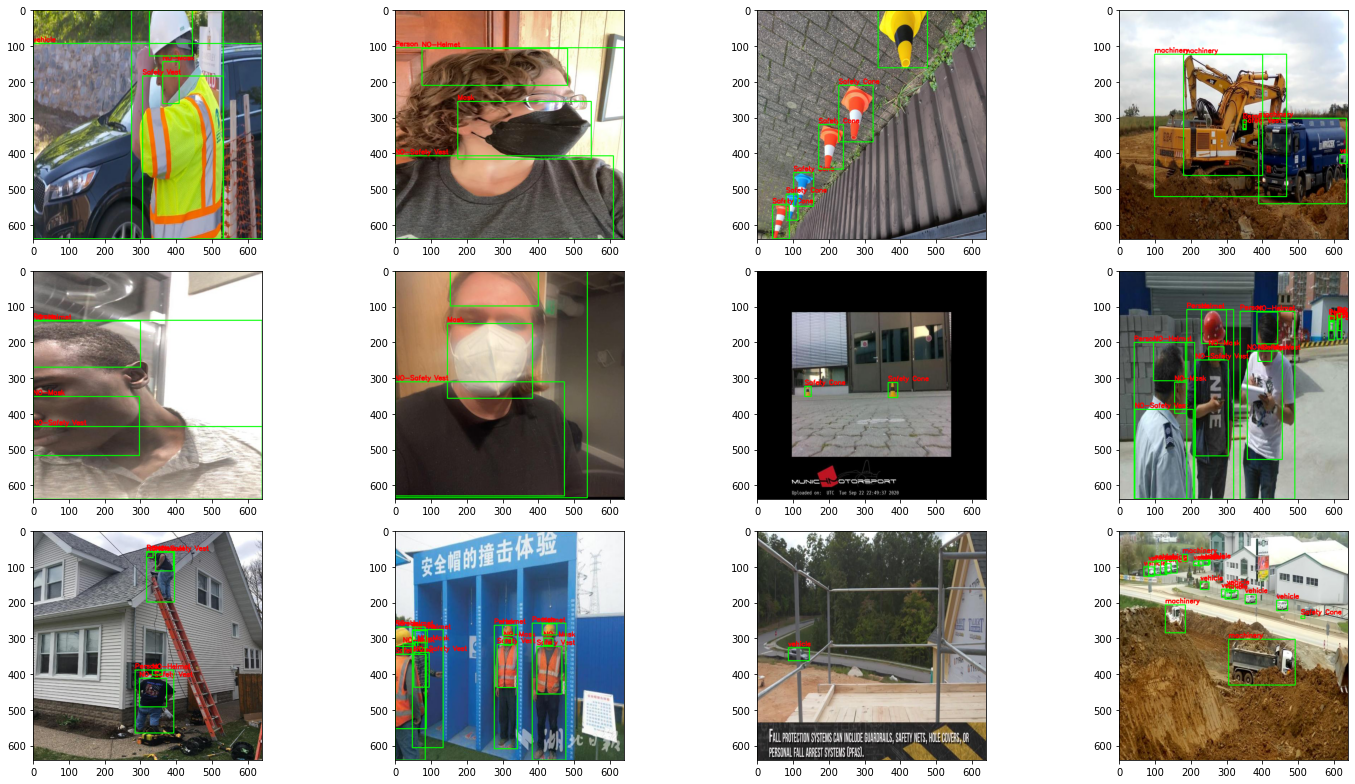

In [ ]:
visualize_samples(mode = 'train', n_samples = 12)

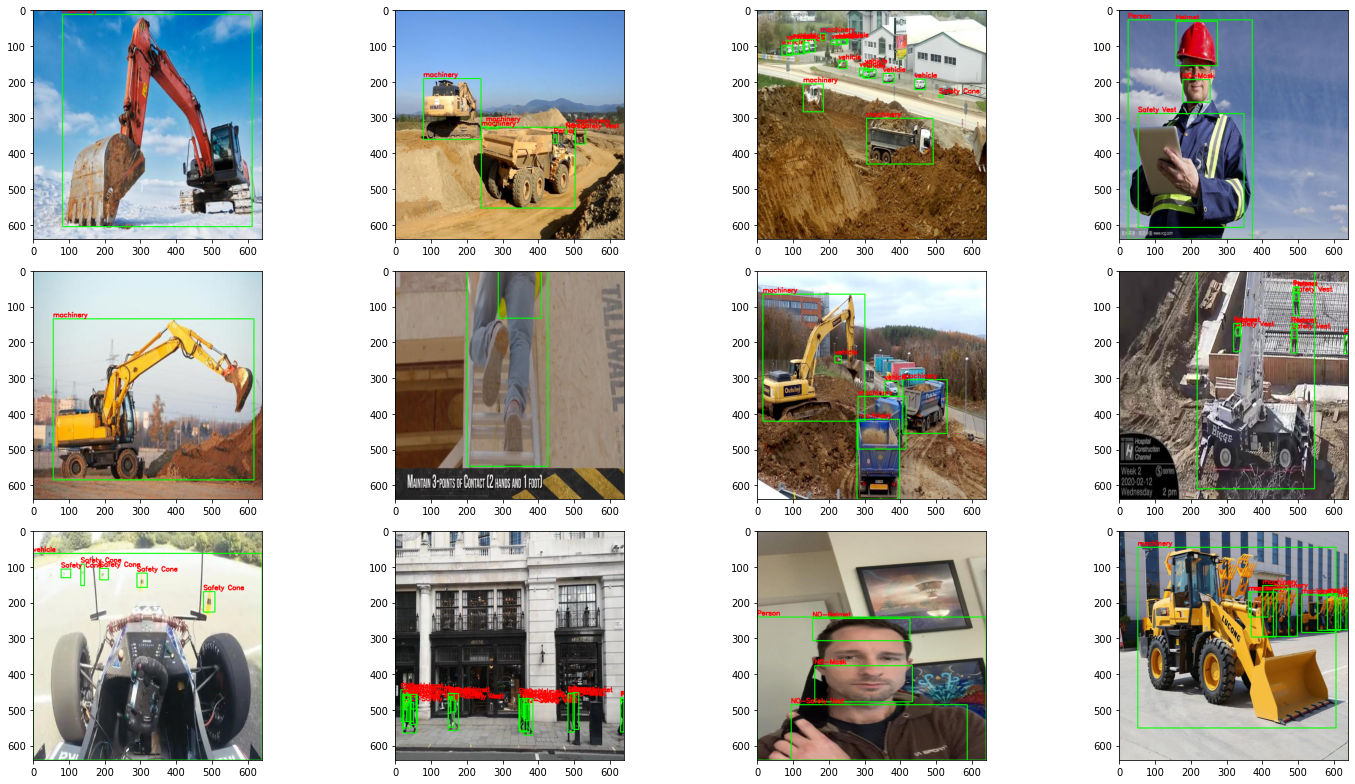

In [ ]:
visualize_samples(mode = 'valid', n_samples = 12)

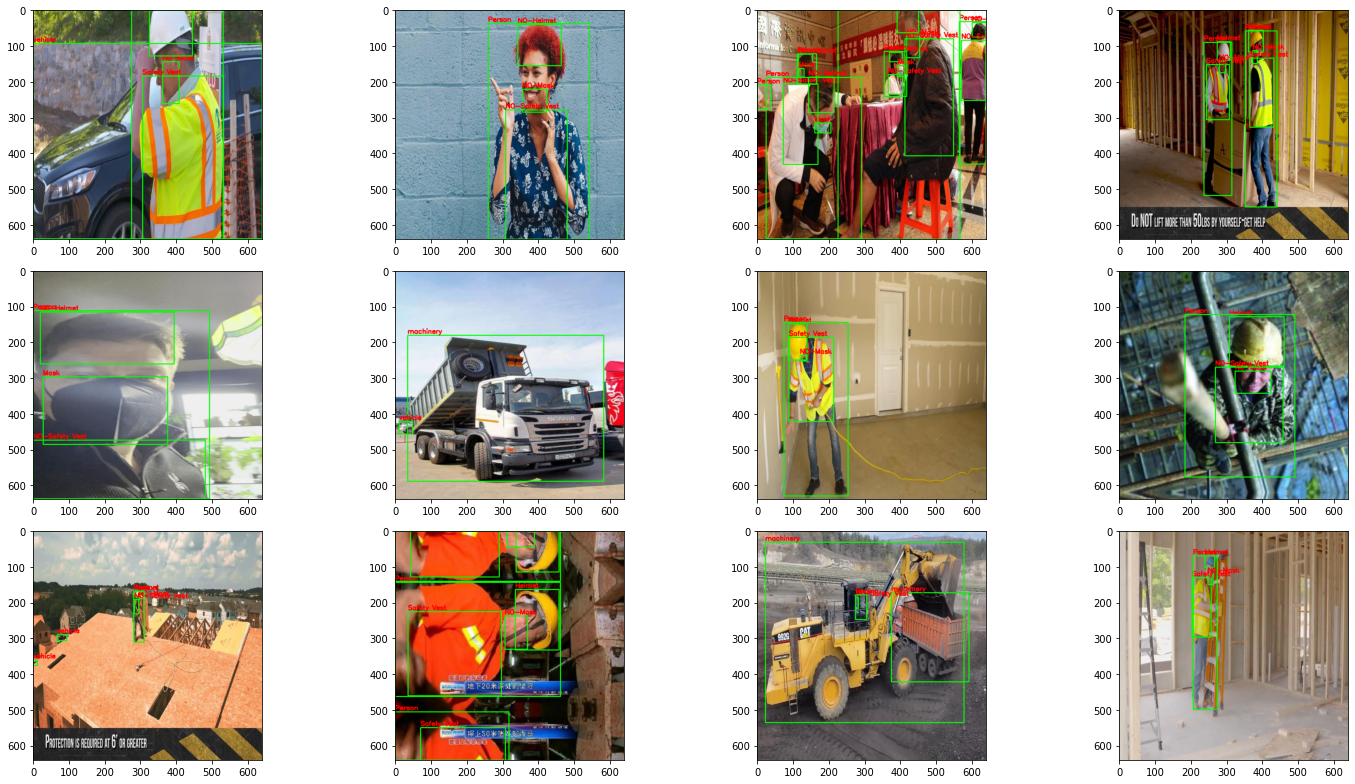

In [ ]:
visualize_samples(mode = 'test', n_samples = 12)